In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import font_manager, rc
from scipy import stats
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.feature_selection import RFE
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
import lightgbm as lgb
from sklearn.model_selection import RandomizedSearchCV
import re
from sklearn.preprocessing import PolynomialFeatures
import xgboost as xgb

C:\Users\soyou\anaconda3\lib\site-packages\dask\dataframe\utils.py:366: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  _numeric_index_types = (pd.Int64Index, pd.Float64Index, pd.UInt64Index)
C:\Users\soyou\anaconda3\lib\site-packages\dask\dataframe\utils.py:366: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  _numeric_index_types = (pd.Int64Index, pd.Float64Index, pd.UInt64Index)
C:\Users\soyou\anaconda3\lib\site-packages\dask\dataframe\utils.py:366: FutureWarning: pandas.UInt64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  _numeric_index_types = (pd.Int64Index, pd.Float64Index, pd.UInt64Index)


In [3]:
# 데이터 불러오기

od = pd.read_csv("taxonomy_data.csv",encoding='cp949')
od

,샘플이름,성별,키(m),몸무게(kg),BMI,나이,d__Bacteria;p__Firmicutes;c__Clostridia;o__Lachnospirales;f__Lachnospiraceae;__;__,d__Bacteria;p__Firmicutes;c__Clostridia;o__Oscillospirales;f__[Eubacterium]_coprostanoligenes_group;g__[Eubacterium]_coprostanoligenes_group;s__metagenome,d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Cytophagales;f__Hymenobacteraceae;g__Hymenobacter;__,d__Bacteria;p__Firmicutes;c__Negativicutes;o__Veillonellales-Selenomonadales;f__Veillonellaceae;g__Dialister;__,...,d__Bacteria;p__Patescibacteria;c__Saccharimonadia;o__Saccharimonadales;f__LWQ8;g__LWQ8;s__uncultured_soil,d__Bacteria;p__Proteobacteria;c__Alphaproteobacteria;o__Rhizobiales;f__Beijerinckiaceae;g__uncultured;s__uncultured_soil,d__Bacteria;p__Acidobacteriota;c__Blastocatellia;o__Pyrinomonadales;f__Pyrinomonadaceae;g__RB41;s__uncultivated_soil,d__Bacteria;p__Firmicutes;c__Clostridia;o__Christensenellales;f__Christensenellaceae;g__Christensenellaceae;s__Christensenella_sp.,d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Chitinophagales;f__Chitinophagaceae;g__Flavisolibacter;__,d__Bacteria;p__Bdellovibrionota;c__Oligoflexia;o__Silvanigrellales;f__Silvanigrellaceae;__;__,d__Bacteria;p__Actinobacteriota;c__Actinobacteria;o__Bifidobacteriales;f__Bifidobacteriaceae;g__Bifidobacterium;s__Bifidobacterium_animalis,d__Bacteria;p__Firmicutes;c__Clostridia;o__Oscillospirales;f__Oscillospiraceae;g__uncultured;s__unidentified,d__Bacteria;p__Firmicutes;c__Clostridia;o__Oscillospirales;f__UCG-010;g__UCG-010;s__bacterium_enrichment,d__Bacteria;p__Actinobacteriota;c__Actinobacteria;o__Actinomycetales;f__Actinomycetaceae;g__Actinotignum;s__Actinotignum_schaalii
0,S0001,남,1.635,62.5,23.380000,57,0.022808,0.000000,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,S0002,남,1.575,62.4,25.154951,63,0.020138,0.000000,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,S0003,여,1.556,55.9,23.088335,63,0.025701,0.000000,0.0,0.000111,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,S0004,여,1.667,67.3,24.218312,62,0.036104,0.002781,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,S0005,여,1.610,59.9,23.108676,43,0.026647,0.000000,0.0,0.034101,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1506,S1507,여,1.612,76.5,29.439563,44,0.022308,0.000000,0.0,0.044838,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1507,S1508,남,1.753,79.8,25.968033,45,0.040610,0.002893,0.0,0.039497,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1508,S1509,남,1.722,71.6,24.146085,53,0.040832,0.000000,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1509,S1510,여,1.546,44.0,18.409148,29,0.015131,0.021139,0.0,0.031041,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [4]:
# 추가 데이터 불러오기
ad = pd.read_csv("additional_data.csv",encoding='cp949')
ad.columns = ['id', 'chao1', 'shannon']
ad.head()

,id,chao1,shannon
0,S0001,184.000000,5.694573
1,S0002,272.500000,6.018361
2,S0003,192.583333,5.667854
3,S0004,164.142857,5.783435
4,S0005,240.000000,5.635428


In [5]:
# 두 데이터 merge 하기
df = pd.merge(od, ad, left_on = "샘플이름", right_on = "id", how = "left")
df = df.drop(['id'], axis = 1)

In [6]:
# 성별에 있는 공백 제거하기
df['성별'] = df['성별'].str.strip()

In [7]:
# 새로 추가된 변수들과 BMI와의 correlation
df[['BMI', 'chao1', 'shannon']].corr()

,BMI,chao1,shannon
BMI,1.000000,-0.108544,-0.098655
chao1,-0.108544,1.000000,0.744843
shannon,-0.098655,0.744843,1.000000


## 전체 BMI 예측

In [8]:
dfX = df[df.columns.difference(['샘플이름','키(m)', '몸무게(kg)', 'BMI'])]
dfy = df['BMI']

Shapiro-Wilk test p-value = 0.0000000000
KS test p-value = 0.0025592520


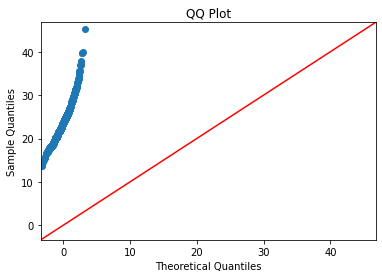

In [14]:
# Normality check

import statsmodels.api as sm

sm.qqplot(dfy, line="45")
plt.title('QQ Plot')
plt.show()

# Shapiro-Wilk test
stat, p = stats.shapiro(dfy)
print("Shapiro-Wilk test p-value = %.10f" % (p))

# Kolmogorov-Smirnov test
m = dfy.mean()
s = dfy.std()
stat, p = stats.kstest(dfy, 'norm', args = (m,s))
print("KS test p-value = %.10f" % (p))



Box-Cox lambda for x1 : -0.3695596125485812
Shapiro-Wilk test p-value = 0.0183036886
KS test p-value = 0.3750056858


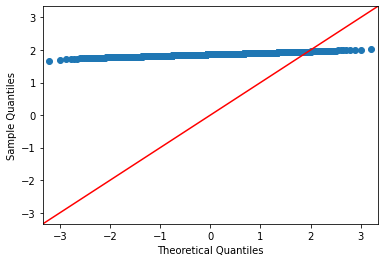

In [15]:
# Box-Cox Transformation

y  = np.array(dfy).reshape(-1)
y_most_normal, lmbda_optimal = stats.boxcox(y)
print("Box-Cox lambda for x1 : {}".format(lmbda_optimal))
#print("Transformed y by Box-Cox : {}".format(y_most_normal))

# qqplot
sm.qqplot(y_most_normal, line="45")

# Shapiro-Wilk test
stat, p = stats.shapiro(y_most_normal)
print("Shapiro-Wilk test p-value = %.10f" % (p))

# Kolmogorov-Smirnov test
m = y_most_normal.mean()
s = y_most_normal.std()
stat, p = stats.kstest(y_most_normal, 'norm', args = (m,s))
print("KS test p-value = %.10f" % (p))

<Axes: >

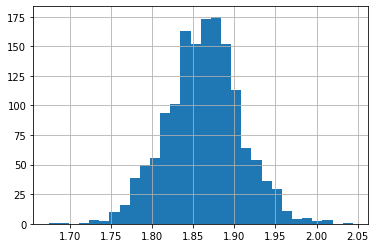

In [18]:
df_normal = pd.DataFrame({'y' : y_most_normal})
df_normal['y'].hist(bins = 30)

<Axes: ylabel='Count'>

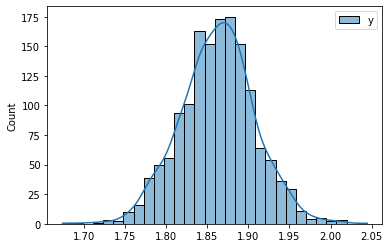

In [23]:
sns.histplot(df_normal, bins = 30, kde = True, stat = "count")

## 값이 대부분 0인 predictors 제외하기

In [9]:
# 90% 이상이 zero value인 column list 만들기

column_list = dfX.columns.tolist()
zero_prop_list = []
for i in range(len(column_list)):
    zero_prop = len(dfX[column_list[i]].loc[dfX[column_list[i]] == 0]) / len(dfX)
    zero_prop_list.append(zero_prop)

df_prop = pd.DataFrame({"var" : column_list, "prop" : zero_prop_list})
zero_var_list = df_prop.loc[df_prop['prop'] >=0.9]['var'].tolist()

new_x_column_list = [element for element in column_list if element not in zero_var_list]

In [10]:
# 해당 컬럼 제외한 새로운 predictor data set 만들기 
dfX_new = dfX[new_x_column_list]
dfX_new.head()

,chao1,d__Bacteria;__;__;__;__;__;__,d__Bacteria;p__Actinobacteriota;c__Actinobacteria;o__Bifidobacteriales;f__Bifidobacteriaceae;g__Bifidobacterium;__,d__Bacteria;p__Actinobacteriota;c__Actinobacteria;o__Bifidobacteriales;f__Bifidobacteriaceae;g__Bifidobacterium;s__Bifidobacterium_bifidum,d__Bacteria;p__Actinobacteriota;c__Actinobacteria;o__Bifidobacteriales;f__Bifidobacteriaceae;g__Bifidobacterium;s__Bifidobacterium_dentium,d__Bacteria;p__Actinobacteriota;c__Actinobacteria;o__Micrococcales;f__Micrococcaceae;g__Rothia;__,d__Bacteria;p__Actinobacteriota;c__Coriobacteriia;o__Coriobacteriales;f__Coriobacteriaceae;g__Collinsella;__,d__Bacteria;p__Actinobacteriota;c__Coriobacteriia;o__Coriobacteriales;f__Eggerthellaceae;g__Eggerthella;__,d__Bacteria;p__Actinobacteriota;c__Coriobacteriia;o__Coriobacteriales;f__Eggerthellaceae;g__Senegalimassilia;s__uncultured_bacterium,d__Bacteria;p__Actinobacteriota;c__Coriobacteriia;o__Coriobacteriales;f__Eggerthellaceae;g__Slackia;__,...,d__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Enterobacterales;f__Pasteurellaceae;g__Haemophilus;__,d__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Pseudomonadales;f__Pseudomonadaceae;g__Pseudomonas;__,d__Bacteria;p__Synergistota;c__Synergistia;o__Synergistales;f__Synergistaceae;g__Cloacibacillus;s__Cloacibacillus_evryensis,d__Bacteria;p__Verrucomicrobiota;c__Lentisphaeria;o__Victivallales;f__Victivallaceae;g__Victivallis;__,d__Bacteria;p__Verrucomicrobiota;c__Lentisphaeria;o__Victivallales;f__Victivallaceae;g__Victivallis;s__Victivallis_vadensis,d__Bacteria;p__Verrucomicrobiota;c__Lentisphaeria;o__Victivallales;f__vadinBE97;g__vadinBE97;s__uncultured_rumen,d__Bacteria;p__Verrucomicrobiota;c__Verrucomicrobiae;o__Verrucomicrobiales;f__Akkermansiaceae;g__Akkermansia;__,shannon,나이,성별
0,184.000000,0.000056,0.004562,0.000000,0.0,0.000334,0.000223,0.0,0.000000,0.000111,...,0.040777,0.0,0.000000,0.000223,0.000111,0.0,0.000000,5.694573,57,남
1,272.500000,0.000000,0.000890,0.000000,0.0,0.000167,0.000000,0.0,0.000000,0.000000,...,0.003894,0.0,0.000000,0.002559,0.000000,0.0,0.000000,6.018361,63,남
2,192.583333,0.000000,0.016522,0.000000,0.0,0.000000,0.011293,0.0,0.000000,0.000000,...,0.005118,0.0,0.000000,0.000111,0.000000,0.0,0.000056,5.667854,63,여
3,164.142857,0.000000,0.005952,0.000000,0.0,0.000000,0.001836,0.0,0.000000,0.000000,...,0.023309,0.0,0.000000,0.000000,0.000000,0.0,0.000000,5.783435,62,여
4,240.000000,0.000779,0.001391,0.000389,0.0,0.000000,0.000890,0.0,0.000111,0.000000,...,0.001558,0.0,0.000056,0.000000,0.000000,0.0,0.005674,5.635428,43,여


In [11]:
# 성별을 남자 1, 여자 0으로 코딩

dfX_new  = pd.get_dummies(dfX_new)
dfX_new = dfX_new.drop(['성별_여'], axis = 1)
dfX_new.rename(columns = {'성별_남' : 'sex', '나이' : 'age'}, inplace = True)
dfX_new.head()

,chao1,d__Bacteria;__;__;__;__;__;__,d__Bacteria;p__Actinobacteriota;c__Actinobacteria;o__Bifidobacteriales;f__Bifidobacteriaceae;g__Bifidobacterium;__,d__Bacteria;p__Actinobacteriota;c__Actinobacteria;o__Bifidobacteriales;f__Bifidobacteriaceae;g__Bifidobacterium;s__Bifidobacterium_bifidum,d__Bacteria;p__Actinobacteriota;c__Actinobacteria;o__Bifidobacteriales;f__Bifidobacteriaceae;g__Bifidobacterium;s__Bifidobacterium_dentium,d__Bacteria;p__Actinobacteriota;c__Actinobacteria;o__Micrococcales;f__Micrococcaceae;g__Rothia;__,d__Bacteria;p__Actinobacteriota;c__Coriobacteriia;o__Coriobacteriales;f__Coriobacteriaceae;g__Collinsella;__,d__Bacteria;p__Actinobacteriota;c__Coriobacteriia;o__Coriobacteriales;f__Eggerthellaceae;g__Eggerthella;__,d__Bacteria;p__Actinobacteriota;c__Coriobacteriia;o__Coriobacteriales;f__Eggerthellaceae;g__Senegalimassilia;s__uncultured_bacterium,d__Bacteria;p__Actinobacteriota;c__Coriobacteriia;o__Coriobacteriales;f__Eggerthellaceae;g__Slackia;__,...,d__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Enterobacterales;f__Pasteurellaceae;g__Haemophilus;__,d__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Pseudomonadales;f__Pseudomonadaceae;g__Pseudomonas;__,d__Bacteria;p__Synergistota;c__Synergistia;o__Synergistales;f__Synergistaceae;g__Cloacibacillus;s__Cloacibacillus_evryensis,d__Bacteria;p__Verrucomicrobiota;c__Lentisphaeria;o__Victivallales;f__Victivallaceae;g__Victivallis;__,d__Bacteria;p__Verrucomicrobiota;c__Lentisphaeria;o__Victivallales;f__Victivallaceae;g__Victivallis;s__Victivallis_vadensis,d__Bacteria;p__Verrucomicrobiota;c__Lentisphaeria;o__Victivallales;f__vadinBE97;g__vadinBE97;s__uncultured_rumen,d__Bacteria;p__Verrucomicrobiota;c__Verrucomicrobiae;o__Verrucomicrobiales;f__Akkermansiaceae;g__Akkermansia;__,shannon,age,sex
0,184.000000,0.000056,0.004562,0.000000,0.0,0.000334,0.000223,0.0,0.000000,0.000111,...,0.040777,0.0,0.000000,0.000223,0.000111,0.0,0.000000,5.694573,57,1
1,272.500000,0.000000,0.000890,0.000000,0.0,0.000167,0.000000,0.0,0.000000,0.000000,...,0.003894,0.0,0.000000,0.002559,0.000000,0.0,0.000000,6.018361,63,1
2,192.583333,0.000000,0.016522,0.000000,0.0,0.000000,0.011293,0.0,0.000000,0.000000,...,0.005118,0.0,0.000000,0.000111,0.000000,0.0,0.000056,5.667854,63,0
3,164.142857,0.000000,0.005952,0.000000,0.0,0.000000,0.001836,0.0,0.000000,0.000000,...,0.023309,0.0,0.000000,0.000000,0.000000,0.0,0.000000,5.783435,62,0
4,240.000000,0.000779,0.001391,0.000389,0.0,0.000000,0.000890,0.0,0.000111,0.000000,...,0.001558,0.0,0.000056,0.000000,0.000000,0.0,0.005674,5.635428,43,0


In [12]:
dfX_new = dfX_new[['age', 'sex'] + [col for col in dfX_new.columns if col not in ['age', 'sex']]]
dfX_new.head()

,age,sex,chao1,d__Bacteria;__;__;__;__;__;__,d__Bacteria;p__Actinobacteriota;c__Actinobacteria;o__Bifidobacteriales;f__Bifidobacteriaceae;g__Bifidobacterium;__,d__Bacteria;p__Actinobacteriota;c__Actinobacteria;o__Bifidobacteriales;f__Bifidobacteriaceae;g__Bifidobacterium;s__Bifidobacterium_bifidum,d__Bacteria;p__Actinobacteriota;c__Actinobacteria;o__Bifidobacteriales;f__Bifidobacteriaceae;g__Bifidobacterium;s__Bifidobacterium_dentium,d__Bacteria;p__Actinobacteriota;c__Actinobacteria;o__Micrococcales;f__Micrococcaceae;g__Rothia;__,d__Bacteria;p__Actinobacteriota;c__Coriobacteriia;o__Coriobacteriales;f__Coriobacteriaceae;g__Collinsella;__,d__Bacteria;p__Actinobacteriota;c__Coriobacteriia;o__Coriobacteriales;f__Eggerthellaceae;g__Eggerthella;__,...,d__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Enterobacterales;f__Enterobacteriaceae;g__Escherichia-Shigella;__,d__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Enterobacterales;f__Pasteurellaceae;__;__,d__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Enterobacterales;f__Pasteurellaceae;g__Haemophilus;__,d__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Pseudomonadales;f__Pseudomonadaceae;g__Pseudomonas;__,d__Bacteria;p__Synergistota;c__Synergistia;o__Synergistales;f__Synergistaceae;g__Cloacibacillus;s__Cloacibacillus_evryensis,d__Bacteria;p__Verrucomicrobiota;c__Lentisphaeria;o__Victivallales;f__Victivallaceae;g__Victivallis;__,d__Bacteria;p__Verrucomicrobiota;c__Lentisphaeria;o__Victivallales;f__Victivallaceae;g__Victivallis;s__Victivallis_vadensis,d__Bacteria;p__Verrucomicrobiota;c__Lentisphaeria;o__Victivallales;f__vadinBE97;g__vadinBE97;s__uncultured_rumen,d__Bacteria;p__Verrucomicrobiota;c__Verrucomicrobiae;o__Verrucomicrobiales;f__Akkermansiaceae;g__Akkermansia;__,shannon
0,57,1,184.000000,0.000056,0.004562,0.000000,0.0,0.000334,0.000223,0.0,...,0.001891,0.000779,0.040777,0.0,0.000000,0.000223,0.000111,0.0,0.000000,5.694573
1,63,1,272.500000,0.000000,0.000890,0.000000,0.0,0.000167,0.000000,0.0,...,0.001279,0.000000,0.003894,0.0,0.000000,0.002559,0.000000,0.0,0.000000,6.018361
2,63,0,192.583333,0.000000,0.016522,0.000000,0.0,0.000000,0.011293,0.0,...,0.005396,0.000111,0.005118,0.0,0.000000,0.000111,0.000000,0.0,0.000056,5.667854
3,62,0,164.142857,0.000000,0.005952,0.000000,0.0,0.000000,0.001836,0.0,...,0.050623,0.000000,0.023309,0.0,0.000000,0.000000,0.000000,0.0,0.000000,5.783435
4,43,0,240.000000,0.000779,0.001391,0.000389,0.0,0.000000,0.000890,0.0,...,0.000389,0.000056,0.001558,0.0,0.000056,0.000000,0.000000,0.0,0.005674,5.635428


## Interaction term 추가

In [14]:
# 위의 feature들로 interaction 추가해보기
from sklearn.preprocessing import PolynomialFeatures

# add interaction terms (x1*x2, but not x1**2) for all remaining features
create_interactions = PolynomialFeatures(degree = 2, interaction_only = True, include_bias = False)
X_poly = create_interactions.fit_transform(dfX_new)
X_poly = pd.DataFrame(X_poly,index=dfy.index)

In [15]:
# save info on which features contribute to each term in X_poly
powers = pd.DataFrame(create_interactions.powers_, columns = dfX_new.columns)
s = np.where(powers > 0, pd.Series(dfX_new.columns)+', ', '')
poly_terms = pd.Series([''.join(x).strip() for x in s])
X_poly.columns = poly_terms

In [16]:
X_poly.head()

,"chao1,","d__Bacteria;__;__;__;__;__;__,","d__Bacteria;p__Actinobacteriota;c__Actinobacteria;o__Bifidobacteriales;f__Bifidobacteriaceae;g__Bifidobacterium;__,","d__Bacteria;p__Actinobacteriota;c__Actinobacteria;o__Bifidobacteriales;f__Bifidobacteriaceae;g__Bifidobacterium;s__Bifidobacterium_bifidum,","d__Bacteria;p__Actinobacteriota;c__Actinobacteria;o__Bifidobacteriales;f__Bifidobacteriaceae;g__Bifidobacterium;s__Bifidobacterium_dentium,","d__Bacteria;p__Actinobacteriota;c__Actinobacteria;o__Micrococcales;f__Micrococcaceae;g__Rothia;__,","d__Bacteria;p__Actinobacteriota;c__Coriobacteriia;o__Coriobacteriales;f__Coriobacteriaceae;g__Collinsella;__,","d__Bacteria;p__Actinobacteriota;c__Coriobacteriia;o__Coriobacteriales;f__Eggerthellaceae;g__Eggerthella;__,","d__Bacteria;p__Actinobacteriota;c__Coriobacteriia;o__Coriobacteriales;f__Eggerthellaceae;g__Senegalimassilia;s__uncultured_bacterium,","d__Bacteria;p__Actinobacteriota;c__Coriobacteriia;o__Coriobacteriales;f__Eggerthellaceae;g__Slackia;__,",...,"d__Bacteria;p__Verrucomicrobiota;c__Lentisphaeria;o__Victivallales;f__vadinBE97;g__vadinBE97;s__uncultured_rumen, d__Bacteria;p__Verrucomicrobiota;c__Verrucomicrobiae;o__Verrucomicrobiales;f__Akkermansiaceae;g__Akkermansia;__,","d__Bacteria;p__Verrucomicrobiota;c__Lentisphaeria;o__Victivallales;f__vadinBE97;g__vadinBE97;s__uncultured_rumen, shannon,","d__Bacteria;p__Verrucomicrobiota;c__Lentisphaeria;o__Victivallales;f__vadinBE97;g__vadinBE97;s__uncultured_rumen, age,","d__Bacteria;p__Verrucomicrobiota;c__Lentisphaeria;o__Victivallales;f__vadinBE97;g__vadinBE97;s__uncultured_rumen, sex,","d__Bacteria;p__Verrucomicrobiota;c__Verrucomicrobiae;o__Verrucomicrobiales;f__Akkermansiaceae;g__Akkermansia;__, shannon,","d__Bacteria;p__Verrucomicrobiota;c__Verrucomicrobiae;o__Verrucomicrobiales;f__Akkermansiaceae;g__Akkermansia;__, age,","d__Bacteria;p__Verrucomicrobiota;c__Verrucomicrobiae;o__Verrucomicrobiales;f__Akkermansiaceae;g__Akkermansia;__, sex,","shannon, age,","shannon, sex,","age, sex,"
0,184.000000,0.000056,0.004562,0.000000,0.0,0.000334,0.000223,0.0,0.000000,0.000111,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,324.590673,5.694573,57.0
1,272.500000,0.000000,0.000890,0.000000,0.0,0.000167,0.000000,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,379.156769,6.018361,63.0
2,192.583333,0.000000,0.016522,0.000000,0.0,0.000000,0.011293,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.000315,0.003503,0.0,357.074772,0.000000,0.0
3,164.142857,0.000000,0.005952,0.000000,0.0,0.000000,0.001836,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,358.572981,0.000000,0.0
4,240.000000,0.000779,0.001391,0.000389,0.0,0.000000,0.000890,0.0,0.000111,0.000000,...,0.0,0.0,0.0,0.0,0.031977,0.243992,0.0,242.323398,0.000000,0.0


## Interaction feature들이 누적 impotance가 90%이하인 feature만 선택하여 추가

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X_poly, y_most_normal, random_state=11)

forest = RandomForestRegressor(max_depth = 11, max_features = "log2", random_state = 2)
forest.fit(X_train, y_train)

print("="*50)
print("Accuracy on Training set :{:.3f}".format(forest.score(X_train, y_train)))
print("Accuracy on Test set :{:.3f}".format(forest.score(X_test, y_test)))
print("="*50)


def re_trans(y, lmbda_optimal):
    result = (y*lmbda_optimal + 1)**(1/lmbda_optimal)
    return result

y_pred = forest.predict(X_test)
y_test_b = re_trans(y_test, lmbda_optimal)
y_pred_b = re_trans(y_pred, lmbda_optimal)

# MAE, MSE, RMSE
from sklearn.metrics import mean_absolute_error, mean_squared_error
print("·MAE:",mean_absolute_error(y_test_b, y_pred_b))
print("·MSE:", mean_squared_error(y_test_b, y_pred_b))
print("·RMSE:", np.sqrt(mean_squared_error(y_test_b, y_pred_b)))
print("="*50)

Accuracy on Training set :0.438
Accuracy on Test set :0.032
·MAE: 2.518661152519639
·MSE: 11.465714995547955
·RMSE: 3.3861061701529613


In [18]:
feature_imp_poly = pd.DataFrame({'features' : X_poly.columns, 'values' : forest.feature_importances_})
feature_imp_poly = feature_imp_poly.sort_values(by = 'values', ascending = False).reset_index().drop(['index'],axis=1)
feature_imp_poly['cum_prop']= feature_imp_poly['values'].cumsum() / feature_imp_poly['values'].sum()

In [19]:
feature_imp_poly

,features,values,cum_prop
0,"chao1, d__Bacteria;p__Firmicutes;c__Clostridia...",0.001569,0.001569
1,d__Bacteria;p__Firmicutes;c__Clostridia;o__Clo...,0.001552,0.003122
2,"shannon, age,",0.001513,0.004635
3,d__Bacteria;p__Firmicutes;c__Clostridia;o__Clo...,0.001327,0.005962
4,d__Bacteria;p__Firmicutes;c__Bacilli;o__Erysip...,0.001281,0.007243
...,...,...,...
43066,d__Bacteria;p__Desulfobacterota;c__Desulfovibr...,0.000000,1.000000
43067,d__Bacteria;p__Desulfobacterota;c__Desulfovibr...,0.000000,1.000000
43068,d__Bacteria;p__Desulfobacterota;c__Desulfovibr...,0.000000,1.000000
43069,d__Bacteria;p__Desulfobacterota;c__Desulfovibr...,0.000000,1.000000


In [20]:
feature_imp_poly['cum_prop'].loc[feature_imp_poly['cum_prop']<=0.9]

0       0.001569
1       0.003122
2       0.004635
3       0.005962
4       0.007243
          ...   
4276    0.899742
4277    0.899806
4278    0.899870
4279    0.899933
4280    0.899997
Name: cum_prop, Length: 4281, dtype: float64

In [21]:
most_imp_features = feature_imp_poly['features'].tolist()[0:4281]
X_poly_selected = X_poly[most_imp_features]
X_poly_selected = X_poly_selected.reset_index().drop(['index'],axis = 1)

In [22]:
X_poly_selected

,"chao1, d__Bacteria;p__Firmicutes;c__Clostridia;o__Lachnospirales;f__Lachnospiraceae;__;__,","d__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridia_vadinBB60_group;f__Clostridia_vadinBB60_group;g__Clostridia_vadinBB60_group;s__uncultured_bacterium, d__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Enterobacterales;__;__;__,","shannon, age,","d__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridia_UCG-014;f__Clostridia_UCG-014;g__Clostridia_UCG-014;__, d__Bacteria;p__Firmicutes;c__Clostridia;o__Oscillospirales;f__Oscillospiraceae;g__UCG-002;__,","d__Bacteria;p__Firmicutes;c__Bacilli;o__Erysipelotrichales;f__Erysipelatoclostridiaceae;g__Coprobacillus;__, d__Bacteria;p__Firmicutes;c__Bacilli;o__Erysipelotrichales;f__Erysipelotrichaceae;g__Holdemanella;__,","d__Bacteria;p__Firmicutes;c__Clostridia;o__Lachnospirales;f__Lachnospiraceae;g__Roseburia;s__Roseburia_hominis, d__Bacteria;p__Verrucomicrobiota;c__Verrucomicrobiae;o__Verrucomicrobiales;f__Akkermansiaceae;g__Akkermansia;__,","d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Bacteroidales;f__Prevotellaceae;g__Prevotella;__, d__Bacteria;p__Firmicutes;c__Bacilli;o__Erysipelotrichales;f__Erysipelatoclostridiaceae;g__Catenibacterium;__,","d__Bacteria;p__Fusobacteriota;c__Fusobacteriia;o__Fusobacteriales;f__Fusobacteriaceae;g__Fusobacterium;s__Fusobacterium_mortiferum, d__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Burkholderiales;f__Comamonadaceae;__;__,","d__Bacteria;p__Firmicutes;c__Clostridia;o__Lachnospirales;f__Lachnospiraceae;g__Eisenbergiella;__, d__Bacteria;p__Firmicutes;c__Clostridia;o__Lachnospirales;f__Lachnospiraceae;g__Lachnoclostridium;__,","d__Bacteria;p__Firmicutes;c__Clostridia;o__Lachnospirales;f__Lachnospiraceae;g__Lachnospiraceae_NK4A136_group;__, sex,",...,"d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Bacteroidales;f__Barnesiellaceae;g__Barnesiella;__, d__Bacteria;p__Firmicutes;c__Clostridia;o__Peptostreptococcales-Tissierellales;f__Peptostreptococcaceae;g__Intestinibacter;__,","d__Bacteria;p__Firmicutes;c__Clostridia;o__Lachnospirales;f__Lachnospiraceae;g__Agathobacter;s__Eubacterium_ramulus, d__Bacteria;p__Firmicutes;c__Negativicutes;o__Veillonellales-Selenomonadales;f__Veillonellaceae;g__Megasphaera;s__Megasphaera_elsdenii,","d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Bacteroidales;f__Bacteroidaceae;g__Bacteroides;s__Bacteroides_cellulosilyticus, d__Bacteria;p__Firmicutes;c__Clostridia;o__Lachnospirales;f__Lachnospiraceae;g__[Eubacterium]_xylanophilum_group;s__uncultured_organism,","d__Bacteria;p__Firmicutes;c__Clostridia;o__Oscillospirales;f__Oscillospiraceae;g__UCG-003;__, d__Bacteria;p__Firmicutes;c__Clostridia;o__Oscillospirales;f__UCG-010;g__UCG-010;__,","d__Bacteria;p__Firmicutes;c__Clostridia;o__Lachnospirales;f__Lachnospiraceae;g__[Eubacterium]_ventriosum_group;s__uncultured_Lachnospiraceae, d__Bacteria;p__Verrucomicrobiota;c__Verrucomicrobiae;o__Verrucomicrobiales;f__Akkermansiaceae;g__Akkermansia;__,","d__Bacteria;p__Firmicutes;c__Clostridia;o__Lachnospirales;f__Lachnospiraceae;g__Agathobacter;__, d__Bacteria;p__Firmicutes;c__Clostridia;o__Oscillospirales;f__Ruminococcaceae;g__DTU089;__,","d__Bacteria;p__Firmicutes;c__Clostridia;o__Lachnospirales;f__Lachnospiraceae;g__Tyzzerella;s__Anaerotignum_lactatifermentans, d__Bacteria;p__Firmicutes;c__Clostridia;o__Lachnospirales;f__Lachnospiraceae;g__uncultured;s__metagenome,","d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Bacteroidales;f__Tannerellaceae;g__Parabacteroides;s__Parabacteroides_merdae, d__Bacteria;p__Firmicutes;c__Clostridia;o__Oscillospirales;f__Oscillospiraceae;g__Oscillibacter;s__uncultured_bacterium,","d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Bacteroidales;f__Bacteroidaceae;g__Bacteroides;s__Bacteroides_stercoris, d__Bacteria;p__Firmicutes;c__Clostridia;o__Lachnospirales;f__Lachnospiraceae;g__Blautia;s__Ruminococcus_sp.,","d__Bacteria;p__Actinobacteriota;c__Actinobacteria;o__Bifidobacteriales;f__Bifidobacteriaceae;g__Bifidobacterium;s__Bifidobacterium_dentium, d__Bacte

## Interaction term을 PCA로 줄여서 넣어보기

In [23]:
from sklearn.preprocessing import StandardScaler  
x = X_poly.values 
y = dfy.values 
x = StandardScaler().fit_transform(x) 

features = X_poly.columns.tolist()
pd.DataFrame(x, columns=features).head()

,"chao1,","d__Bacteria;__;__;__;__;__;__,","d__Bacteria;p__Actinobacteriota;c__Actinobacteria;o__Bifidobacteriales;f__Bifidobacteriaceae;g__Bifidobacterium;__,","d__Bacteria;p__Actinobacteriota;c__Actinobacteria;o__Bifidobacteriales;f__Bifidobacteriaceae;g__Bifidobacterium;s__Bifidobacterium_bifidum,","d__Bacteria;p__Actinobacteriota;c__Actinobacteria;o__Bifidobacteriales;f__Bifidobacteriaceae;g__Bifidobacterium;s__Bifidobacterium_dentium,","d__Bacteria;p__Actinobacteriota;c__Actinobacteria;o__Micrococcales;f__Micrococcaceae;g__Rothia;__,","d__Bacteria;p__Actinobacteriota;c__Coriobacteriia;o__Coriobacteriales;f__Coriobacteriaceae;g__Collinsella;__,","d__Bacteria;p__Actinobacteriota;c__Coriobacteriia;o__Coriobacteriales;f__Eggerthellaceae;g__Eggerthella;__,","d__Bacteria;p__Actinobacteriota;c__Coriobacteriia;o__Coriobacteriales;f__Eggerthellaceae;g__Senegalimassilia;s__uncultured_bacterium,","d__Bacteria;p__Actinobacteriota;c__Coriobacteriia;o__Coriobacteriales;f__Eggerthellaceae;g__Slackia;__,",...,"d__Bacteria;p__Verrucomicrobiota;c__Lentisphaeria;o__Victivallales;f__vadinBE97;g__vadinBE97;s__uncultured_rumen, d__Bacteria;p__Verrucomicrobiota;c__Verrucomicrobiae;o__Verrucomicrobiales;f__Akkermansiaceae;g__Akkermansia;__,","d__Bacteria;p__Verrucomicrobiota;c__Lentisphaeria;o__Victivallales;f__vadinBE97;g__vadinBE97;s__uncultured_rumen, shannon,","d__Bacteria;p__Verrucomicrobiota;c__Lentisphaeria;o__Victivallales;f__vadinBE97;g__vadinBE97;s__uncultured_rumen, age,","d__Bacteria;p__Verrucomicrobiota;c__Lentisphaeria;o__Victivallales;f__vadinBE97;g__vadinBE97;s__uncultured_rumen, sex,","d__Bacteria;p__Verrucomicrobiota;c__Verrucomicrobiae;o__Verrucomicrobiales;f__Akkermansiaceae;g__Akkermansia;__, shannon,","d__Bacteria;p__Verrucomicrobiota;c__Verrucomicrobiae;o__Verrucomicrobiales;f__Akkermansiaceae;g__Akkermansia;__, age,","d__Bacteria;p__Verrucomicrobiota;c__Verrucomicrobiae;o__Verrucomicrobiales;f__Akkermansiaceae;g__Akkermansia;__, sex,","shannon, age,","shannon, sex,","age, sex,"
0,-0.207308,-0.644278,-0.238837,-0.170141,-0.218964,0.334000,-0.434437,-0.209089,-0.296842,0.264206,...,-0.109972,-0.210784,-0.186603,-0.145934,-0.233463,-0.209807,-0.096825,0.426555,1.519974,1.395605
1,1.075689,-0.702395,-0.407483,-0.170141,-0.218964,0.125688,-0.458189,-0.209089,-0.296842,-0.255263,...,-0.109972,-0.210784,-0.186603,-0.145934,-0.233463,-0.209807,-0.096825,0.895854,1.648501,1.613993
2,-0.082875,-0.702395,0.310541,-0.170141,-0.218964,-0.082625,0.747236,-0.209089,-0.296842,-0.255263,...,-0.109972,-0.210784,-0.186603,-0.145934,-0.231465,-0.207677,-0.096825,0.705936,-0.740463,-0.679085
3,-0.495180,-0.702395,-0.174956,-0.170141,-0.218964,-0.082625,-0.262233,-0.209089,-0.296842,-0.255263,...,-0.109972,-0.210784,-0.186603,-0.145934,-0.233463,-0.209807,-0.096825,0.718822,-0.740463,-0.679085
4,0.604532,0.111679,-0.384486,0.161947,-0.218964,-0.082625,-0.363180,-0.209089,-0.062562,-0.255263,...,-0.109972,-0.210784,-0.186603,-0.145934,-0.030686,-0.061427,-0.096825,-0.280990,-0.740463,-0.679085


In [24]:
from sklearn.decomposition import PCA
# Create principal components
pca = PCA()
X_pca = pca.fit_transform(x)
# Convert to dataframe
component_names = [f"PC{i+1}" for i in range(X_pca.shape[1])]
X_pca = pd.DataFrame(X_pca, columns=component_names)
print('X_pca shape', X_pca.shape)
X_pca.head()

X_pca shape (1511, 1511)


,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC1502,PC1503,PC1504,PC1505,PC1506,PC1507,PC1508,PC1509,PC1510,PC1511
0,-14.356459,-17.925352,-0.261819,-1.173701,6.907919,6.041939,-1.142694,8.938141,10.233202,-8.725139,...,-0.068830,0.003225,-0.068300,0.000240,0.063859,-0.035515,0.021944,-0.011132,-0.003743,9.679852e-14
1,21.535086,-31.325325,23.543487,-0.286643,2.211262,6.386835,-0.306851,-20.071671,14.650398,-19.765020,...,0.050628,-0.012988,-0.031245,0.014162,-0.016934,0.005097,-0.004269,0.004716,-0.000513,9.679852e-14
2,-13.595881,-11.793241,0.124684,-7.851147,10.266453,-1.060567,-7.144313,13.515708,11.001580,-6.792865,...,0.021270,0.006846,0.016908,0.027876,-0.002072,0.017983,0.015529,0.039497,0.000078,9.679852e-14
3,-17.685070,-4.562415,-4.386265,-3.447131,5.651525,6.835833,-6.290210,10.662451,9.544521,-1.845138,...,-0.020104,0.045323,-0.092248,0.001330,0.009878,-0.028191,0.078822,0.054307,0.000380,9.679852e-14
4,5.290155,-25.266208,-12.712201,-7.113419,3.771262,-4.321994,-2.710332,7.158805,3.163161,-7.435453,...,0.002051,0.025454,0.028268,0.010661,0.013448,0.020265,-0.004442,0.010397,0.000205,9.679852e-14


Text(0.5, 1.0, 'Scree Plot')

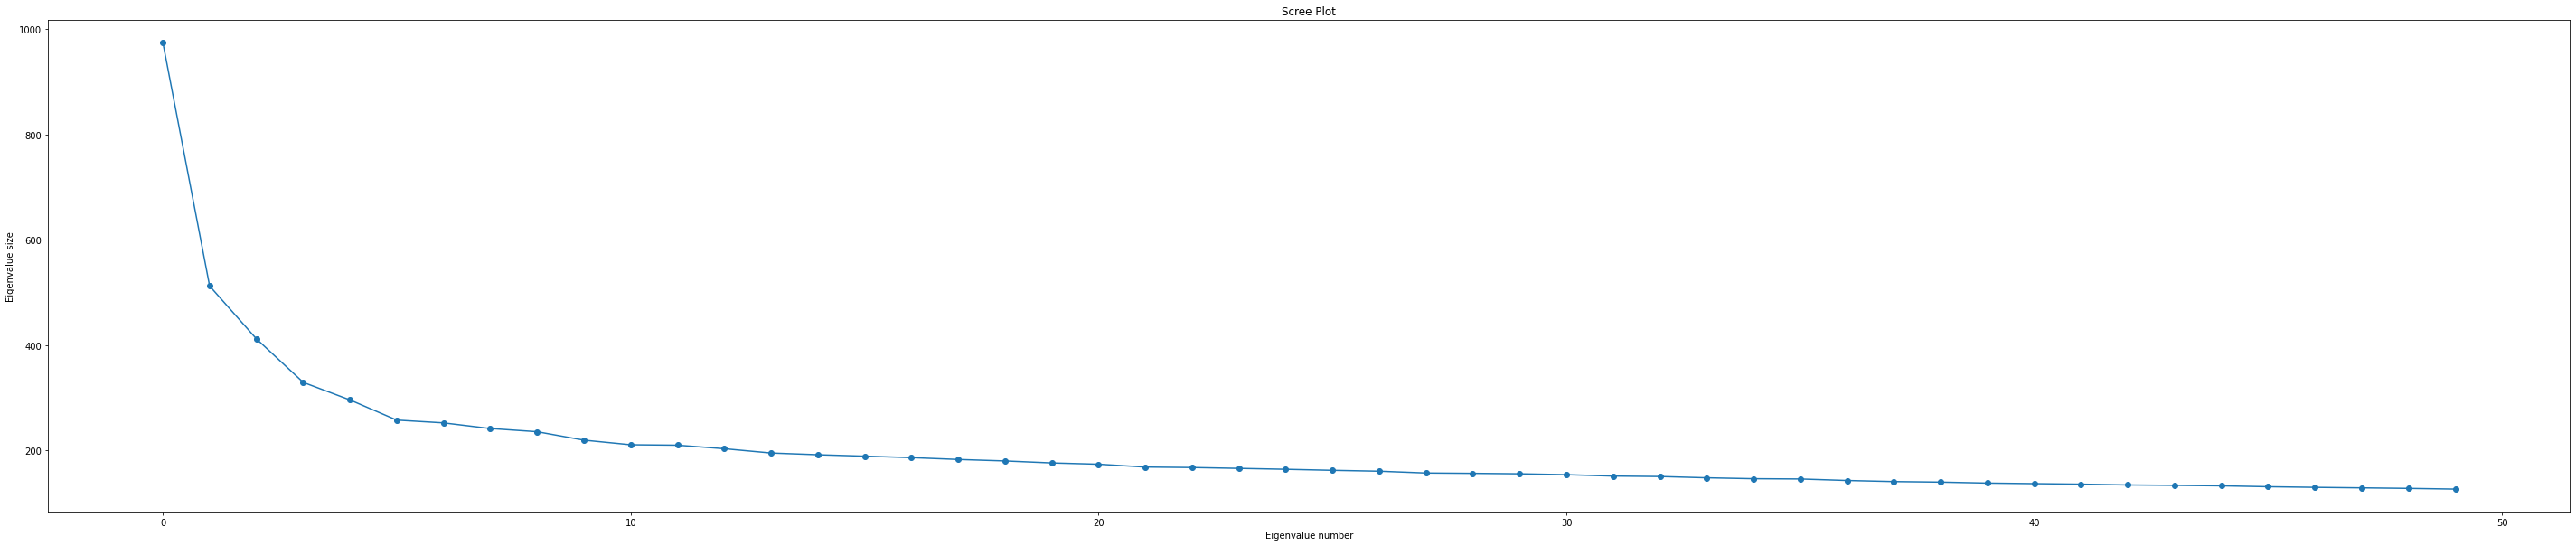

In [25]:
# scree plot
plt.figure(figsize=(50,10))
plt.plot(pca.explained_variance_[0:50], marker='o')
plt.xlabel("Eigenvalue number")
plt.ylabel("Eigenvalue size")
plt.title("Scree Plot")

In [26]:
X_pca_inter = X_pca.iloc[:,0:50]
X_pca_inter
dfX_pca = pd.concat([X_poly_selected, X_pca_inter], axis = 1)
dfX_pca.head()

,"chao1, d__Bacteria;p__Firmicutes;c__Clostridia;o__Lachnospirales;f__Lachnospiraceae;__;__,","d__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridia_vadinBB60_group;f__Clostridia_vadinBB60_group;g__Clostridia_vadinBB60_group;s__uncultured_bacterium, d__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Enterobacterales;__;__;__,","shannon, age,","d__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridia_UCG-014;f__Clostridia_UCG-014;g__Clostridia_UCG-014;__, d__Bacteria;p__Firmicutes;c__Clostridia;o__Oscillospirales;f__Oscillospiraceae;g__UCG-002;__,","d__Bacteria;p__Firmicutes;c__Bacilli;o__Erysipelotrichales;f__Erysipelatoclostridiaceae;g__Coprobacillus;__, d__Bacteria;p__Firmicutes;c__Bacilli;o__Erysipelotrichales;f__Erysipelotrichaceae;g__Holdemanella;__,","d__Bacteria;p__Firmicutes;c__Clostridia;o__Lachnospirales;f__Lachnospiraceae;g__Roseburia;s__Roseburia_hominis, d__Bacteria;p__Verrucomicrobiota;c__Verrucomicrobiae;o__Verrucomicrobiales;f__Akkermansiaceae;g__Akkermansia;__,","d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Bacteroidales;f__Prevotellaceae;g__Prevotella;__, d__Bacteria;p__Firmicutes;c__Bacilli;o__Erysipelotrichales;f__Erysipelatoclostridiaceae;g__Catenibacterium;__,","d__Bacteria;p__Fusobacteriota;c__Fusobacteriia;o__Fusobacteriales;f__Fusobacteriaceae;g__Fusobacterium;s__Fusobacterium_mortiferum, d__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Burkholderiales;f__Comamonadaceae;__;__,","d__Bacteria;p__Firmicutes;c__Clostridia;o__Lachnospirales;f__Lachnospiraceae;g__Eisenbergiella;__, d__Bacteria;p__Firmicutes;c__Clostridia;o__Lachnospirales;f__Lachnospiraceae;g__Lachnoclostridium;__,","d__Bacteria;p__Firmicutes;c__Clostridia;o__Lachnospirales;f__Lachnospiraceae;g__Lachnospiraceae_NK4A136_group;__, sex,",...,PC41,PC42,PC43,PC44,PC45,PC46,PC47,PC48,PC49,PC50
0,4.196707,0.0,324.590673,0.000016,0.0,0.000000,0.000000,0.0,0.0,0.030207,...,3.710985,-2.045759,-7.567533,-2.359223,-1.471931,6.386982,-6.413382,-13.032237,-0.735807,-1.892504
1,5.487595,0.0,379.156769,0.000282,0.0,0.000000,0.000029,0.0,0.0,0.003894,...,12.291004,-4.188447,-4.694444,-3.266649,8.869326,2.666348,-22.475778,-7.147853,-8.378579,-11.277054
2,4.949572,0.0,357.074772,0.000000,0.0,0.000001,0.000166,0.0,0.0,0.000000,...,-11.971150,1.202633,2.683157,4.899183,-10.274249,6.971124,-15.175290,-2.595825,6.731651,4.677079
3,5.926163,0.0,358.572981,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,...,0.406574,-0.485003,-0.847763,0.727501,-2.895191,-0.483378,0.095152,-0.791757,5.921213,1.079172
4,6.395194,0.0,242.323398,0.000163,0.0,0.000002,0.000000,0.0,0.0,0.000000,...,-0.394832,-2.422083,8.308632,4.972990,-2.767967,12.722293,-0.115520,-0.843074,-5.151715,4.917660


## Best train,test set split

### Random Forest

In [29]:
def rf_model(X_train, y_train, X_test, y_test):
    # random forest

    forest = RandomForestRegressor(max_depth = 11, max_features = "log2", random_state = 2)
    forest.fit(X_train, y_train)

    #print("="*50)
    #print("Accuracy on Training set :{:.3f}".format(forest.score(X_train, y_train)))
    #print("Accuracy on Test set :{:.3f}".format(forest.score(X_test, y_test)))
    #print("="*50)


    def re_trans(y, lmbda_optimal):
        result = (y*lmbda_optimal + 1)**(1/lmbda_optimal)
        return result

    y_pred = forest.predict(X_test)
    y_test_b = re_trans(y_test, lmbda_optimal)
    y_pred_b = re_trans(y_pred, lmbda_optimal)

    # MAE, MSE, RMSE
    from sklearn.metrics import mean_absolute_error, mean_squared_error
    #print("·MAE:",mean_absolute_error(y_test_b, y_pred_b))
    #print("·MSE:", mean_squared_error(y_test_b, y_pred_b))
    #print("·RMSE:", np.sqrt(mean_squared_error(y_test_b, y_pred_b)))
    #print("="*50)
    MAE = mean_absolute_error(y_test_b, y_pred_b)
    
    return MAE
    

In [30]:
mae_list = []
for i in range(100):
    X_train, X_test, y_train, y_test = train_test_split(dfX_pca, y_most_normal, random_state=i)
    mae = rf_model(X_train, y_train, X_test, y_test)
    mae_list.append(mae)


In [31]:
pd.DataFrame({'mae' : mae_list}).sort_values(by='mae')

,mae
12,2.369325
69,2.396325
64,2.396407
46,2.414321
63,2.417808
...,...
45,2.781437
82,2.789826
76,2.809985
48,2.832532


In [102]:
# Best_train_test_set_split : random_state = 12

X_train, X_test, y_train, y_test = train_test_split(dfX_pca, y_most_normal, random_state = 12)

forest = RandomForestRegressor(max_depth = 11, max_features = "log2", random_state = 2)
forest.fit(X_train, y_train)

print("="*50)
print("Accuracy on Training set :{:.3f}".format(forest.score(X_train, y_train)))
print("Accuracy on Test set :{:.3f}".format(forest.score(X_test, y_test)))
print("="*50)

y_pred = forest.predict(X_test)
y_test_b = re_trans(y_test, lmbda_optimal)
y_pred_b = re_trans(y_pred, lmbda_optimal)

# MAE, MSE, RMSE
from sklearn.metrics import mean_absolute_error, mean_squared_error
print("·MAE:",mean_absolute_error(y_test_b, y_pred_b))
print("·MSE:", mean_squared_error(y_test_b, y_pred_b))
print("·RMSE:", np.sqrt(mean_squared_error(y_test_b, y_pred_b)))
print("="*50)

Accuracy on Training set :0.515
Accuracy on Test set :0.120
·MAE: 2.369324973929524
·MSE: 9.085166913435062
·RMSE: 3.0141610629551736


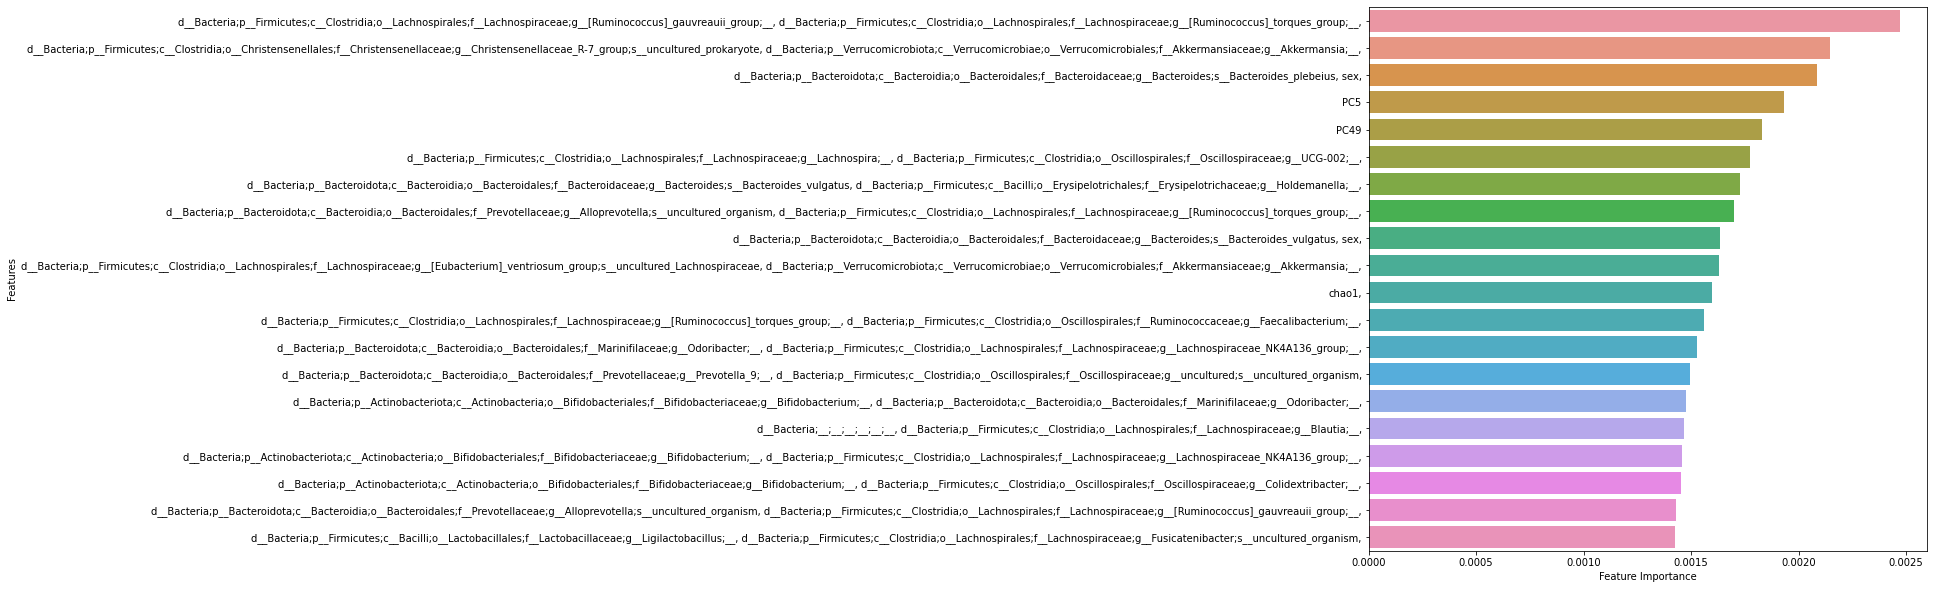

In [146]:
# Model Feature importance

feature_imp = pd.DataFrame({'Features' : forest.feature_names_in_, 'Feature Importance' : forest.feature_importances_})
feature_imp = feature_imp.sort_values(by = 'Feature Importance', ascending = False).reset_index(drop = True)

plt.figure(figsize= (10,10))
sns.barplot(x = 'Feature Importance', y = 'Features', data = feature_imp[0:20])
plt.show()

## SHAP Importance

In [107]:
import shap

In [108]:
# DF, based on which importance is checked
X_importance = X_test

# Explain model predictions using shap library:
explainer = shap.TreeExplainer(forest)
shap_values = explainer.shap_values(X_importance)

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.


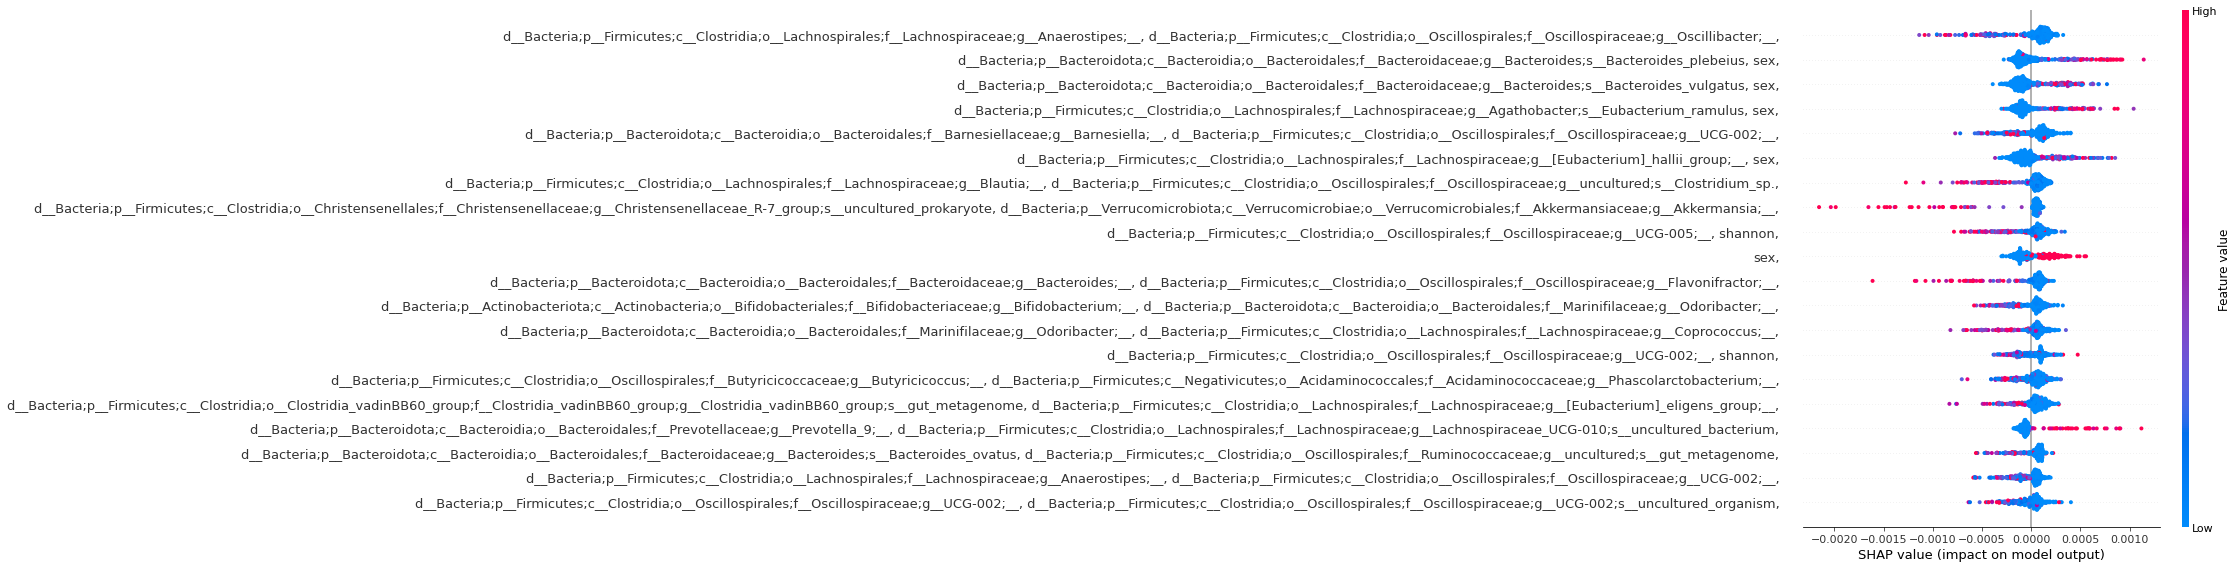

In [109]:
# Plot summary_plot
shap.summary_plot(shap_values, X_importance)

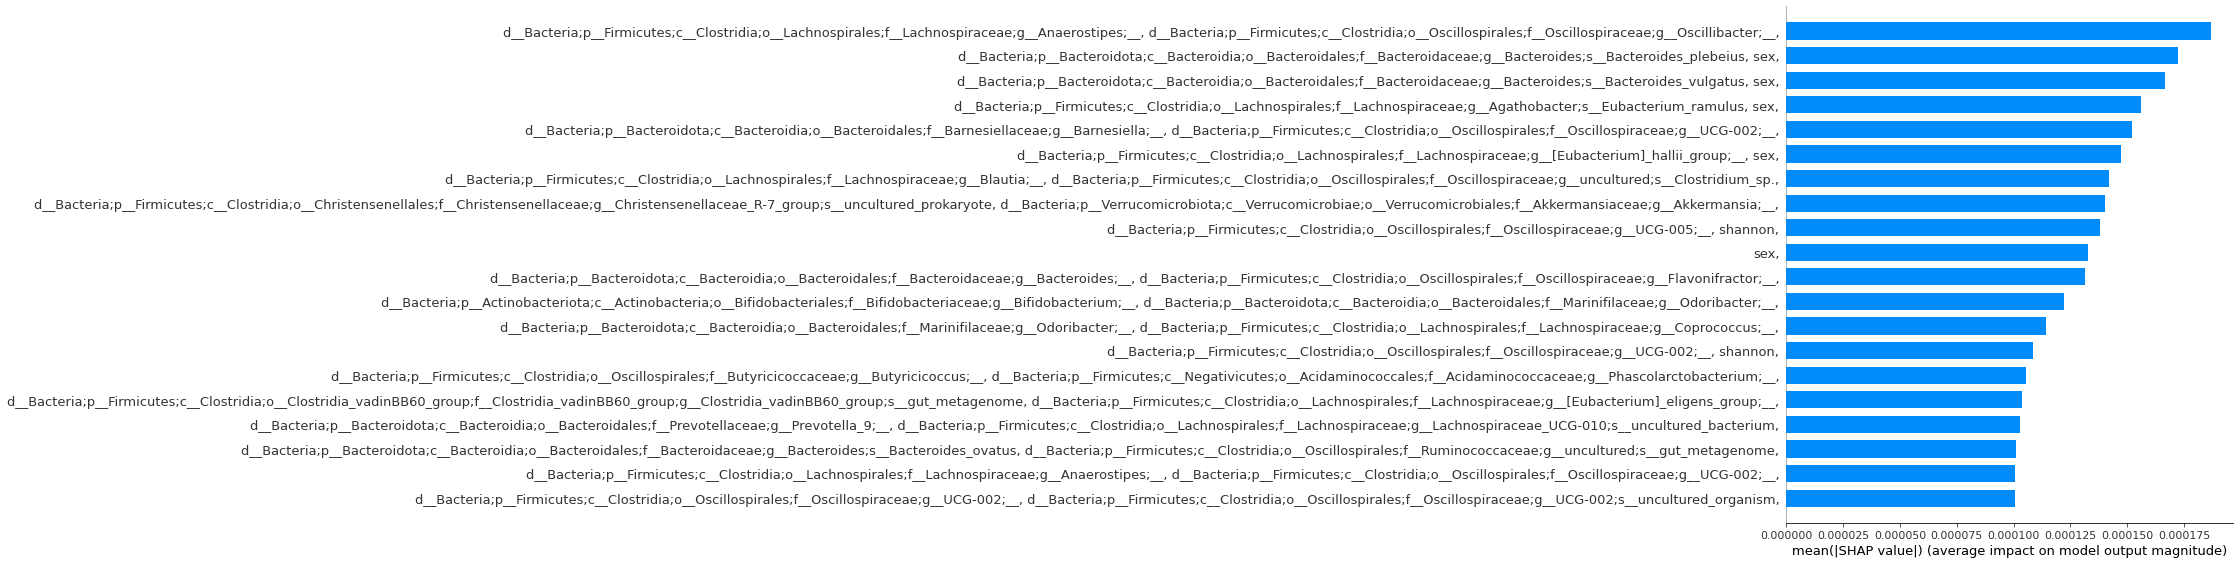

In [110]:
# Plot summary_plot as barplot:
shap.summary_plot(shap_values, X_importance, plot_type='bar')

In [132]:
shap_sum = np.abs(shap_values).mean(axis=0)
importance_df = pd.DataFrame([X_importance.columns.tolist(), shap_sum.tolist()]).T
importance_df.columns = ['column_name', 'shap_importance']
importance_df = importance_df.sort_values('shap_importance', ascending=False)
importance_df['column_name'][0:10].tolist()

['d__Bacteria;p__Firmicutes;c__Clostridia;o__Lachnospirales;f__Lachnospiraceae;g__Anaerostipes;__, d__Bacteria;p__Firmicutes;c__Clostridia;o__Oscillospirales;f__Oscillospiraceae;g__Oscillibacter;__,',
 'd__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Bacteroidales;f__Bacteroidaceae;g__Bacteroides;s__Bacteroides_plebeius, sex,',
 'd__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Bacteroidales;f__Bacteroidaceae;g__Bacteroides;s__Bacteroides_vulgatus, sex,',
 'd__Bacteria;p__Firmicutes;c__Clostridia;o__Lachnospirales;f__Lachnospiraceae;g__Agathobacter;s__Eubacterium_ramulus, sex,',
 'd__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Bacteroidales;f__Barnesiellaceae;g__Barnesiella;__, d__Bacteria;p__Firmicutes;c__Clostridia;o__Oscillospirales;f__Oscillospiraceae;g__UCG-002;__,',
 'd__Bacteria;p__Firmicutes;c__Clostridia;o__Lachnospirales;f__Lachnospiraceae;g__[Eubacterium]_hallii_group;__, sex,',
 'd__Bacteria;p__Firmicutes;c__Clostridia;o__Lachnospirales;f__Lachnospiraceae;g__Blautia;__, d__Bacter

In [138]:
# Model feature importance와 Shap importance 중 겹치는 것. 

set(feature_imp['Features'][0:20].tolist()) & set(importance_df['column_name'][0:20].tolist())

{'d__Bacteria;p__Actinobacteriota;c__Actinobacteria;o__Bifidobacteriales;f__Bifidobacteriaceae;g__Bifidobacterium;__, d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Bacteroidales;f__Marinifilaceae;g__Odoribacter;__,',
 'd__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Bacteroidales;f__Bacteroidaceae;g__Bacteroides;s__Bacteroides_plebeius, sex,',
 'd__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Bacteroidales;f__Bacteroidaceae;g__Bacteroides;s__Bacteroides_vulgatus, sex,',
 'd__Bacteria;p__Firmicutes;c__Clostridia;o__Christensenellales;f__Christensenellaceae;g__Christensenellaceae_R-7_group;s__uncultured_prokaryote, d__Bacteria;p__Verrucomicrobiota;c__Verrucomicrobiae;o__Verrucomicrobiales;f__Akkermansiaceae;g__Akkermansia;__,'}

### Xgboost

In [64]:
# xgboost

def xgbmodel(dfX, dfy, random_state):
    
    X_train, X_test, y_train, y_test = train_test_split(dfX, dfy, random_state=random_state)

    regex = re.compile(r"\[|\]|<", re.IGNORECASE)
    X_train.columns = [regex.sub("_", col) if any(x in str(col) for x in set(('[', ']', '<'))) else col for col in X_train.columns.values]
    X_test.columns = [regex.sub("_", col) if any(x in str(col) for x in set(('[', ']', '<'))) else col for col in X_test.columns.values]

    xgb_model = xgb.XGBRegressor(objective = 'reg:squarederror', random_state =0)
    xgb_model.fit(X_train, y_train)
    y_pred = xgb_model.predict(X_test)
    #feature_importance = xgb_model.feature_importances_

    #Print("="*50)
    #print('·train score:',xgb_model.score(X_train, y_train))
    #print('·validation score:',xgb_model.score(X_test, y_test))

    # Box-cox transformation 역변환
    def re_trans(y, lmbda_optimal):
        result = (y*lmbda_optimal + 1)**(1/lmbda_optimal)
        return result

    y_test = re_trans(y_test, lmbda_optimal)
    y_pred = re_trans(y_pred, lmbda_optimal)

    #print("·MAE:", mean_absolute_error(y_test, y_pred))
    #print("·MSE:", mean_squared_error(y_test, y_pred))
    #print("·RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))
    #print("="*50)
    MAE = mean_absolute_error(y_test, y_pred)
    return MAE

In [67]:
mae_list_xgb = []
for i in range(100):
    mae = xgbmodel(dfX_pca, y_most_normal, i)
    mae_list_xgb.append(mae)
mae_list_xgb

[2.7269768407619575,
 2.7825799119528543,
 2.720165880869657,
 3.006848584883718,
 2.7975086405407525,
 2.658376773654889,
 2.829331184086436,
 2.7634221838930104,
 2.821600465643331,
 2.575767647644405,
 2.8044882584704536,
 2.696230816182972,
 2.5533678380392923,
 2.876973047381264,
 2.6743023599895372,
 2.8232084814660587,
 2.9414229076720493,
 2.8717641860799925,
 2.7778804376584922,
 2.9898687422118364,
 2.878815816759194,
 2.8314451331555888,
 2.7493636866395277,
 2.733129430762623,
 2.6014167490328677,
 2.902720397436523,
 2.7015730617664424,
 2.7704219000395027,
 2.9520236839012783,
 2.738753290249888,
 2.7238752168793665,
 2.757861996548717,
 2.708583212372376,
 2.7466608261788505,
 2.8167382514731627,
 2.8362813723328864,
 2.7936806765629383,
 2.660130135625078,
 2.8415906904992867,
 2.6395364186029737,
 2.6271997855146445,
 2.6955152760960366,
 2.7947607366236262,
 2.7595584649120717,
 2.8060920760890293,
 2.9581234909799474,
 2.584488548065528,
 2.83165125132022,
 2.8583890

In [68]:
pd.DataFrame({'mae' : mae_list_xgb}).sort_values(by='mae')

,mae
69,2.497308
64,2.527286
12,2.553368
9,2.575768
46,2.584489
...,...
45,2.958123
19,2.989869
82,3.003511
3,3.006849


In [57]:
# lightgbm

def lightgbm_model(dfX, dfy, random_state):
    
    dfX = dfX.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))

    X_train, X_test, y_train, y_test = train_test_split(dfX, dfy ,random_state = random_state)

    model = lgb.LGBMRegressor(random_state = 0)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    #print('='*50)
    #print("Best model train set score : {}".format(model.score(X_train, y_train)))
    #print("Best model test set score : {}".format(model.score(X_test, y_test)))
    #print('='*50)

    # Box-cox transformation 역변환
    def re_trans(y, lmbda_optimal):
        result = (y*lmbda_optimal + 1)**(1/lmbda_optimal)
        return result

    y_test = re_trans(y_test, lmbda_optimal)
    y_pred = re_trans(y_pred, lmbda_optimal)

    #print("·MAE:", mean_absolute_error(y_test, y_pred))
    #print("·MSE:", mean_squared_error(y_test, y_pred))
    #print("·RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))
    #print("="*50)
    
    MAE = mean_absolute_error(y_test, y_pred)
    return MAE
    

In [60]:
mae_list_lgb = []
for i in range(100):
    mae = lightgbm_model(dfX_pca, y_most_normal, i)
    mae_list_lgb.append(mae)

In [63]:
pd.DataFrame({'mae' : mae_list_lgb}).sort_values(by='mae')

,mae
12,2.365206
46,2.413666
64,2.447863
69,2.453901
32,2.460306
...,...
36,2.809665
48,2.827997
19,2.850801
54,2.864843


## K-fold cross validation

In [95]:
from sklearn.model_selection import KFold

In [139]:
# Random Forest

kf = KFold(n_splits = 5, shuffle= True)

X = dfX_pca.copy()
y = y_most_normal.copy()

test_mae_total_rf = []
for train_index, test_index in kf.split(X):
    # X_train, X_test 정의
    
    X_train, X_test = X.loc[train_index], X.loc[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    model = RandomForestRegressor(max_depth = 11, max_features = "log2", random_state = 2)
    model.fit(X_train, y_train)
    
    #train_pred = model.predict(X_train) # 훈련셋 예측
    test_pred = model.predict(X_test) # 시험셋 예측
    
    def re_trans(y, lmbda_optimal):
        result = (y*lmbda_optimal + 1)**(1/lmbda_optimal)
        return result
    
    y_test = re_trans(y_test, lmbda_optimal)
    y_pred = re_trans(test_pred, lmbda_optimal)

    test_mae = mean_absolute_error(y_test, y_pred)
    test_mae_total_rf.append(test_mae)

print(test_mae_total_rf)
print(np.mean(test_mae_total_rf))


[2.46475569796818, 2.69722014141159, 2.5928096303082744, 2.6168995226336262, 2.6546917746087932]
2.605275353386093


In [88]:
# xgboost

kf = KFold(n_splits = 5, shuffle= True)

X = dfX_pca.copy()
y = y_most_normal.copy()

regex = re.compile(r"\[|\]|<", re.IGNORECASE)
X.columns = [regex.sub("_", col) if any(x in str(col) for x in set(('[', ']', '<'))) else col for col in X.columns.values]

train_mae_total = []
test_mae_total = []
for train_index, test_index in kf.split(X):
    # X_train, X_test 정의
    
    X_train, X_test = X.loc[train_index], X.loc[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    model = xgb.XGBRegressor(objective = 'reg:squarederror', random_state = 0)
    model.fit(X_train, y_train)
    train_pred = model.predict(X_train) # 훈련셋 예측
    test_pred = model.predict(X_test) # 시험셋 예측
    
    def re_trans(y, lmbda_optimal):
        result = (y*lmbda_optimal + 1)**(1/lmbda_optimal)
        return result
    
    y_test = re_trans(y_test, lmbda_optimal)
    y_pred = re_trans(test_pred, lmbda_optimal)

    test_mae = mean_absolute_error(y_test, y_pred)
    test_mae_total.append(test_mae)

test_mae_total

[2.645406286559873,
 2.8125220372759254,
 2.681869252553922,
 2.7936475599414066,
 2.7520050704537784]

In [94]:
np.mean(test_mae_total)

2.737090041356981

In [99]:
# lightgbm

kf = KFold(n_splits = 5, shuffle= True)

X = dfX_pca.copy()
y = y_most_normal.copy()

X = X.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))

train_mae_total = []
test_mae_total = []
for train_index, test_index in kf.split(X):
    # X_train, X_test 정의
    
    X_train, X_test = X.loc[train_index], X.loc[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    model = lgb.LGBMRegressor(random_state = 0)
    model.fit(X_train, y_train)
    train_pred = model.predict(X_train) # 훈련셋 예측
    test_pred = model.predict(X_test) # 시험셋 예측
    
    def re_trans(y, lmbda_optimal):
        result = (y*lmbda_optimal + 1)**(1/lmbda_optimal)
        return result
    
    y_test = re_trans(y_test, lmbda_optimal)
    y_pred = re_trans(test_pred, lmbda_optimal)

    test_mae = mean_absolute_error(y_test, y_pred)
    test_mae_total.append(test_mae)

print(test_mae_total)
print(np.mean(test_mae_total))

[2.6622077954161707, 2.521259650812886, 2.618141666705897, 2.697781350711518, 2.4621755954099336]
2.5923132118112813
